In [1]:
#Code is adapted from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

import pandas as pd
gba_data=pd.read_csv("Data LIWC 01 02 23.csv")
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

# Separate feature columns (X) and target variable column (y), remove features used to calculate buzz eg retweet counts due to multicollinearity
X = gba_data.drop(columns=['Corrected_Sentiment_Flag', 'DateDay', 'conversation_id', 'id', 'Date1', '3-Phase', 'Total_Sentiment', 'Corrected_Sentiment',
                           'we.1', 'tentat', 'Drives', 'emo_pos', 'emo_neg', 'we','insight', 'cause', 'discrep', 'certitude','Positive', 'Negative', 'Sno', 'X', 'retweet_count', 'like_count', 'reply_count', 'quote_count'])
y = gba_data['Corrected_Sentiment_Flag']

# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing steps for numerical and categorical features
numeric_transformer = QuantileTransformer(output_distribution='normal')  #normalise using QuantileTransformer which transforms features to follow a uniform or a normal distribution, reduce impact of outliers

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
    ])

# Apply preprocessing to the data
X_transformed = preprocessor.fit_transform(X)

# Convert the transformed numerical features back to a DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=numerical_features)

# Concatenate the original categorical features with the transformed numerical features
X= pd.concat([X_transformed_df, X[categorical_features]], axis=1)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify categorical features
categorical_features_indices = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

# Create preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ~X.columns.isin(X.columns[categorical_features_indices])),  # numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.columns[categorical_features_indices])  # categorical features
    ])

# Combine preprocessing with SMOTE-NC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])



# Resample the training data using SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

#Prepare for Classification
X_train_preprocessed_resampled = pipeline.fit_transform(X_train_resampled)

# Get the feature names from the preprocessor (one-hot encoding)
encoded_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=X.columns[categorical_features_indices])

# Concatenate the original feature names with the encoded feature names
all_feature_names = list(X.columns.drop(X.columns[categorical_features_indices])) + list(encoded_feature_names)
print(all_feature_names)


#Initialise the Logistic Regression classifier
logreg = LogisticRegression(random_state=42)

#Identify Most relevant features using Recursive Feature Elimination
rfe = RFE(estimator=logreg, n_features_to_select=30)
rfe = rfe.fit(X_train_preprocessed_resampled, y_train_resampled.values.ravel())
print(rfe.support_) #Is a selected feature?
print(rfe.ranking_) #Estimated best feature by rank


Class distribution after resampling:
1    13577
0    13577
Name: Corrected_Sentiment_Flag, dtype: int64
['Buzz', 'Followers', 'WC', 'Clout', 'Cognition', 'Affect', 'emotion', 'i', 'they', 'State_Assam', 'State_Bihar', 'State_Chattisgarh', 'State_Delhi', 'State_Goa', 'State_Gujarat', 'State_HP', 'State_J and K', 'State_Jharkhand', 'State_Karnataka', 'State_Kerala', 'State_MP', 'State_Maharashtra', 'State_Mizoram', 'State_Nagaland', 'State_Odisha', 'State_Rajasthan', 'State_Tamilnadu', 'State_Telangana', 'State_Tripura', 'State_UP', 'State_Uttarkhand', 'State_WestBengal', 'OpnHours_Non-working Hours', 'OpnHours_Working Hours', 'Day_weekday', 'Day_weekend', 'Time_Business hours', 'Time_Non-buisness hours', '4-phase_Covid Lockdown', '4-phase_Post Lockdown', '4-phase_Pre-Covid', '4-phase_Unlocking', 'Vividness_Poll', 'Vividness_link', 'Vividness_photo', 'Vividness_text', 'Vividness_video', 'ContentType_Information', 'ContentType_Interaction']


C:\Users\manym\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\manym\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[False  True  True False False  True False False False  True False  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True False  True False False False  True  True False False  True
  True  True False False  True False  True  True False  True  True False
  True]
[11  1  1 19 16  1  9 15 13  1  6  1  1  1  1  1  1  1  1  1  7  1  1  1
  1  1  5  1 20 14 17  1  1 12  8  1  1  1  2  3  1  4  1  1 10  1  1 18
  1]


C:\Users\manym\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\manym\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [2]:
# Get the selected Most Important feature names
selected_feature_names = np.array(all_feature_names)[rfe.support_]

# Print the selected feature names
print(selected_feature_names)

print(X_train_preprocessed_resampled)
print(y_train_resampled)

['Followers' 'WC' 'Affect' 'State_Assam' 'State_Chattisgarh' 'State_Delhi'
 'State_Goa' 'State_Gujarat' 'State_HP' 'State_J and K' 'State_Jharkhand'
 'State_Karnataka' 'State_Kerala' 'State_Maharashtra' 'State_Mizoram'
 'State_Nagaland' 'State_Odisha' 'State_Rajasthan' 'State_Telangana'
 'State_WestBengal' 'OpnHours_Non-working Hours' 'Day_weekend'
 'Time_Business hours' 'Time_Non-buisness hours' '4-phase_Pre-Covid'
 'Vividness_Poll' 'Vividness_link' 'Vividness_text' 'Vividness_video'
 'ContentType_Interaction']
[[ 1.21013726  5.19933758  0.50207379 ...  0.          1.
   0.        ]
 [-0.20978711  0.98561042  0.087933   ...  0.          1.
   0.        ]
 [ 0.1017956   0.98561042  0.62566982 ...  0.          0.
   1.        ]
 ...
 [ 0.86200016 -0.67342694  0.18292756 ...  0.          1.
   0.        ]
 [-0.57480016 -1.34020047 -0.55640431 ...  0.          1.
   0.        ]
 [-0.91442242 -0.58958332 -1.23093423 ...  0.          1.
   0.        ]]
0        1
1        0
2        0
3    

In [3]:
#Create new PD Dataframe for resampled training data
X_resampled_data = pd.DataFrame(data=X_train_preprocessed_resampled,columns=all_feature_names )
y_resampled_data= pd.DataFrame(data=y_train_resampled,columns=['Corrected_Sentiment_Flag'])
#Replace Original Resampled Training Data with the RFE Selected features.
columns=['Followers', 'WC', 'Affect', 'State_Assam', 'State_Chattisgarh', 'State_Delhi',
 'State_Goa', 'State_Gujarat', 'State_HP', 'State_J and K', 'State_Jharkhand',
 'State_Karnataka', 'State_Kerala', 'State_Maharashtra', 'State_Mizoram',
 'State_Nagaland', 'State_Odisha', 'State_Rajasthan', 'State_Telangana',
 'State_WestBengal', 'OpnHours_Non-working Hours', 'Day_weekend',
 'Time_Business hours', 'Time_Non-buisness hours', '4-phase_Pre-Covid',
 'Vividness_Poll', 'Vividness_link', 'Vividness_text', 'Vividness_video',
 'ContentType_Interaction']           




X_train_Final=X_resampled_data[columns]
y_train_Final=y_resampled_data
display(X_train_Final)
display(y_train_Final)

,Followers,WC,Affect,State_Assam,State_Chattisgarh,State_Delhi,State_Goa,State_Gujarat,State_HP,State_J and K,...,OpnHours_Non-working Hours,Day_weekend,Time_Business hours,Time_Non-buisness hours,4-phase_Pre-Covid,Vividness_Poll,Vividness_link,Vividness_text,Vividness_video,ContentType_Interaction
0,5.199338,0.502074,-0.653377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.985610,0.087933,0.186756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.985610,0.625670,-0.016310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.710366,-0.170185,-1.298271,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.212353,0.182928,-0.532190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27149,0.363878,0.957151,-0.784179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
27150,0.136804,1.460885,-0.256340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27151,-0.673427,0.182928,0.691121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27152,-1.340200,-0.556404,1.218567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,Corrected_Sentiment_Flag
0,1
1,0
2,0
3,0
4,0
...,...
27149,1
27150,1
27151,1
27152,1


In [4]:
logit_model=sm.Logit(y_train_Final,X_train_Final)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.559853
         Iterations 7
                              Results: Logit
Model:                Logit                    Pseudo R-squared: 0.192     
Dependent Variable:   Corrected_Sentiment_Flag AIC:              30464.4816
Date:                 2024-03-18 17:13         BIC:              30710.7600
No. Observations:     27154                    Log-Likelihood:   -15202.   
Df Model:             29                       LL-Null:          -18822.   
Df Residuals:         27124                    LLR p-value:      0.0000    
Converged:            1.0000                   Scale:            1.0000    
No. Iterations:       7.0000                                               
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Followers        

In [5]:
#Since all p values are significant, ,0.05, we can proceed to use all of them.

#Fit and train the regressor Model at last!
logreg = LogisticRegression(C=1.0, class_weight=None, dual=False, random_state=42, max_iter=1000, solver='liblinear', tol=0.00000001, warm_start=False)
logreg.fit(X_train_Final, y_train_Final)

# Evaluate the classifier on the training set
y_train_pred = logreg.predict(X_train_Final)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_Final, y_train_pred)

print("Training Accuracy:", train_accuracy)


#Encode X test variables as well to make predictions
X_test_preprocessed = pipeline.fit_transform(X_test)

#Create new PD Dataframe for testing data
X_test_preprocessed = pd.DataFrame(data=X_test_preprocessed,columns=all_feature_names )
y_test_preprocessed = pd.DataFrame(data=y_test, columns=['Corrected_Sentiment_Flag'])
columns2=['Followers', 'WC', 'Affect', 'State_Assam', 'State_Chattisgarh', 'State_Delhi',
 'State_Goa', 'State_Gujarat', 'State_HP', 'State_J and K', 'State_Jharkhand',
 'State_Karnataka', 'State_Kerala', 'State_Maharashtra', 'State_Mizoram',
 'State_Nagaland', 'State_Odisha', 'State_Rajasthan', 'State_Telangana',
 'State_WestBengal', 'OpnHours_Non-working Hours', 'Day_weekend',
 'Time_Business hours', 'Time_Non-buisness hours', '4-phase_Pre-Covid',
 'Vividness_Poll', 'Vividness_link', 'Vividness_text', 'Vividness_video',
 'ContentType_Interaction']
X_test_preprocessed = X_test_preprocessed[columns2]

#Evaluate the classifier on the testing set
y_pred = logreg.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test_preprocessed, y_pred)
sensitivity = recall_score(y_test_preprocessed, y_pred)
conf_matrix = confusion_matrix(y_test_preprocessed, y_pred)
auc_roc_score = roc_auc_score(y_test_preprocessed, y_pred)
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("AUC-ROC Score:", auc_roc_score)

Training Accuracy: 0.7140384473742358
Accuracy: 0.6821211243117937
Sensitivity (True Positive Rate): 0.6411214953271028
AUC-ROC Score: 0.6653824211889287


C:\Users\manym\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


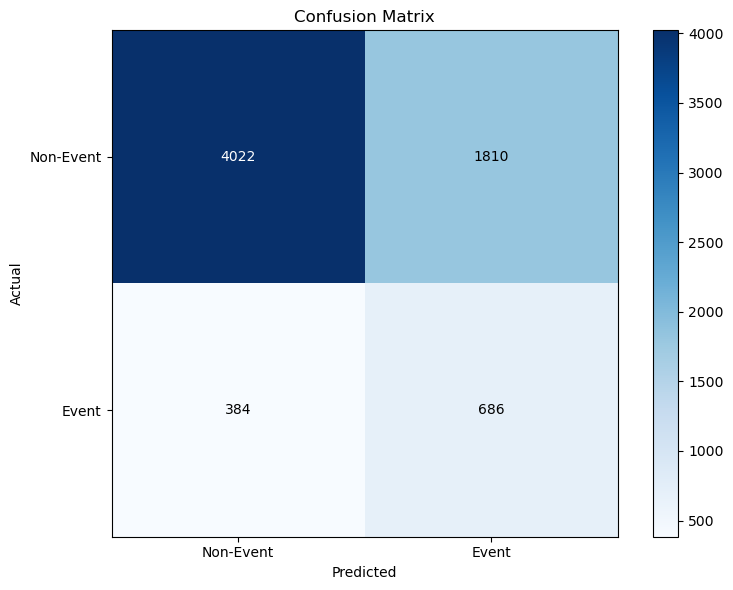

In [6]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Non-Event', 'Event']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

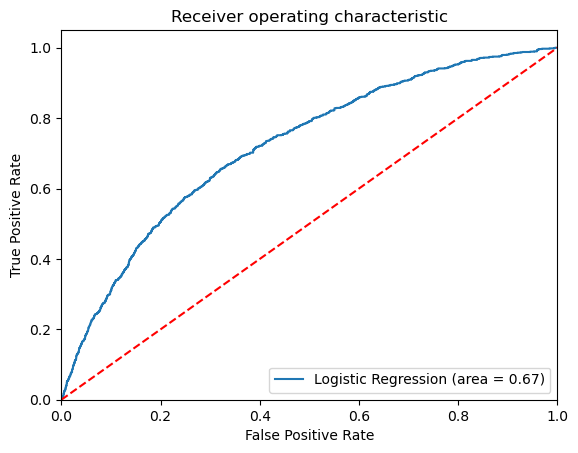

In [7]:
#plot auc-roc
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_preprocessed))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_preprocessed)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()